kitti_label可视化

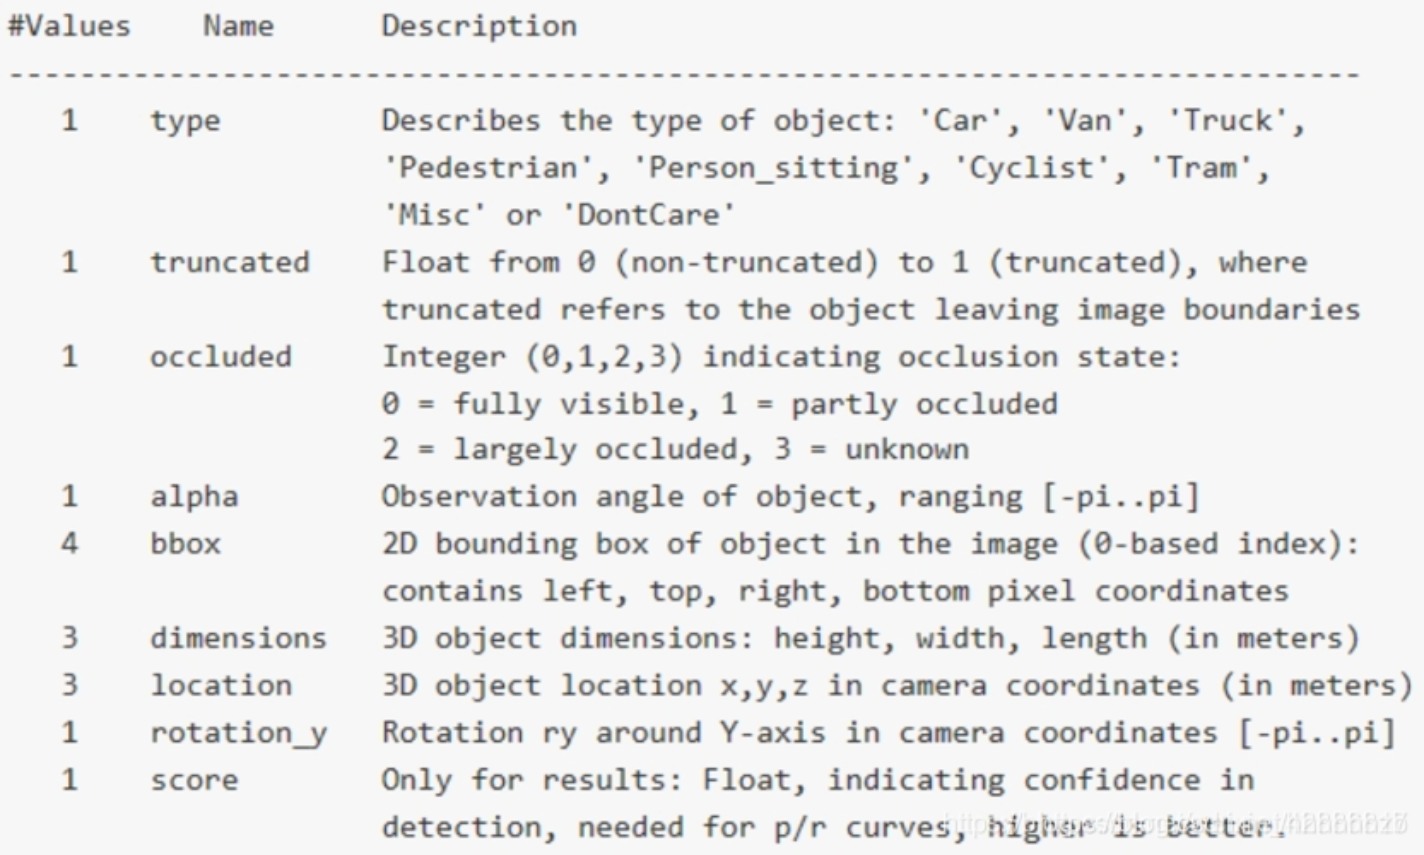

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import yaml
import json
import pandas as pd
# from kitti_util import *
from matplotlib.lines import Line2D
import cv2
import open3d as o3d

In [12]:
def get_anns():
    anns = []
    label_path = 'D:\lidar\point\\000008\\000008_label.txt'
    with open(label_path, 'r') as lf:
        labels = lf.readlines()
        labels = [label.rstrip() for label in labels]
    for label in labels:
        ann_format = {}
        ann = label.split(" ")
        class_name = ann[0]
        ann_format["class_name"]=class_name
        ann_ = [float(x) for x in ann[1:]]
        truncation = ann_[0] # truncated pixel ratio [0..1]
        ann_format["truncation"]=truncation
        occlusion = ann_[1] # 0=visible, 1=partly occluded, 2=fully occluded, 3=unknown
        ann_format["occlusion"]=occlusion
        alpha = ann_[2]
        ann_format["alpha"]=alpha # object observation angle [-pi..pi]

        #2D box
        xmin, ymin, xmax, ymax = ann_[3], ann_[4], ann_[5], ann_[6]
        box2d = np.array([xmin, ymin, xmax, ymax])
        ann_format["box2d"]=box2d

        #3D box
        box3d = {}
        h, w, l = ann_[7], ann_[8], ann_[9]
        cx, cy, cz = ann_[10], ann_[11], ann_[12]
        box3d["dim"] = np.array([l, w, h])
        box3d["center"] = np.array([cx, cy, cz])
        yaw = ann_[13]
        box3d["rotation"] = yaw# yaw angle [-pi..pi]
        ann_format["box3d"]=box3d

        anns.append(ann_format)
    return anns

In [14]:
bbox = []
anns = get_anns()
for ann in anns:
    bbox.append(ann["box3d"])
bbox

[{'dim': array([3.23, 1.57, 1.6 ]),
  'center': array([-2.7 ,  1.74,  3.68]),
  'rotation': -1.29},
 {'dim': array([3.68, 1.5 , 1.57]),
  'center': array([-1.17,  1.65,  7.86]),
  'rotation': 1.9},
 {'dim': array([3.08, 1.44, 1.39]),
  'center': array([3.81, 1.64, 6.15]),
  'rotation': -1.31},
 {'dim': array([3.66, 1.6 , 1.47]),
  'center': array([ 1.07,  1.55, 14.44]),
  'rotation': -1.25},
 {'dim': array([4.08, 1.63, 1.7 ]),
  'center': array([ 7.24,  1.55, 33.2 ]),
  'rotation': 1.95},
 {'dim': array([2.47, 1.59, 1.59]),
  'center': array([ 8.48,  1.75, 19.96]),
  'rotation': -1.25},
 {'dim': array([-1., -1., -1.]),
  'center': array([-1000., -1000., -1000.]),
  'rotation': -10.0},
 {'dim': array([-1., -1., -1.]),
  'center': array([-1000., -1000., -1000.]),
  'rotation': -10.0},
 {'dim': array([-1., -1., -1.]),
  'center': array([-1000., -1000., -1000.]),
  'rotation': -10.0},
 {'dim': array([-1., -1., -1.]),
  'center': array([-1000., -1000., -1000.]),
  'rotation': -10.0}]

In [16]:
def gen_3dbox(bbox3d):
    corners_3d_all = []
    for box in bbox3d:
        center = box["center"]
        l, w, h = box["dim"]
        angle = box["rotation"]
        c, s = np.cos(angle), np.sin(angle)
        R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
        # 3d bounding box corners
        x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
        y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
        z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]

        corners = np.vstack([x_corners, y_corners, z_corners])
        corners_3d = np.dot(R, corners)
        corners_3d[0, :] += center[0]
        corners_3d[1, :] += center[1]
        corners_3d[2, :] += center[2]
        corners_3d_all.append(corners_3d)
    return corners_3d_all

bbox3d = gen_3dbox(bbox)

In [17]:
print(bbox3d)

[array([[-2.25244979, -2.25244979, -3.14755021, -3.14755021, -3.78978589,
        -3.78978589, -4.68488632, -4.68488632],
       [ 0.18825137,  0.18825137,  3.29174863,  3.29174863, -0.25514203,
        -0.25514203,  2.84835523,  2.84835523],
       [ 4.465     ,  2.895     ,  2.895     ,  4.465     ,  4.465     ,
         2.895     ,  2.895     ,  4.465     ]]), array([[-1.7648528 , -1.7648528 , -0.5751472 , -0.5751472 , -0.27916167,
        -0.27916167,  0.91054394,  0.91054394],
       [ 3.39119216,  3.39119216, -0.09119216, -0.09119216,  3.89875678,
         3.89875678,  0.41637246,  0.41637246],
       [ 8.61      ,  7.11      ,  7.11      ,  8.61      ,  8.61      ,
         7.11      ,  7.11      ,  8.61      ]]), array([[ 4.20708905,  4.20708905,  3.41291095,  3.41291095,  2.86409197,
         2.86409197,  2.06991387,  2.06991387],
       [ 0.15207517,  0.15207517,  3.12792483,  3.12792483, -0.20633637,
        -0.20633637,  2.76951328,  2.76951328],
       [ 6.87      ,  5.43 

In [18]:
with open(f'D:\lidar\point\\000008\\000008.txt','r') as f:
    calib = f.readlines()

P2 = np.array([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3, 4)
K = np.array(P2[:12]).reshape(3, 4)[:3, :3]

# 从字符串解析出从激光雷达到相机的变换矩阵
Tr_velo_to_cam = np.array([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3, 4)
Tr_velo_to_cam = np.insert(Tr_velo_to_cam, 3, values=[0, 0, 0, 1], axis=0)
Tr = np.array([Tr_velo_to_cam[0,3],Tr_velo_to_cam[1,3],Tr_velo_to_cam[2,3]])

R0_rect = np.array([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3, 3)
# R0_rect = np.insert(R0_rect, 3, values=[0, 0, 0], axis=0)
# R0_rect = np.insert(R0_rect, 3, values=[0, 0, 0, 1], axis=1)


# 输出相机内参矩阵和外参矩阵
print("P2:")
print(P2)
print(K)
print('Tr_velo2cam:')
print(Tr_velo_to_cam)
print('T:')
print(Tr)
print('R0_rect:')
print(R0_rect)

P2:
[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
[[721.5377   0.     609.5593]
 [  0.     721.5377 172.854 ]
 [  0.       0.       1.    ]]
Tr_velo2cam:
[[ 7.533745e-03 -9.999714e-01 -6.166020e-04 -4.069766e-03]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01 -7.631618e-02]
 [ 9.998621e-01  7.523790e-03  1.480755e-02 -2.717806e-01]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]
T:
[-0.00406977 -0.07631618 -0.2717806 ]
R0_rect:
[[ 0.9999239   0.00983776 -0.00744505]
 [-0.0098698   0.9999421  -0.00427846]
 [ 0.00740253  0.00435161  0.9999631 ]]


In [19]:
def project_box3d(bbox3d, P):
    project_xy = []
    project_z = []
    for box3d in bbox3d:
        if np.any(box3d[2, :] < 0.1):
            continue
        box3d = np.concatenate([box3d, np.zeros((1, 8))], axis=0)
        project_3dbox = np.dot(P, box3d)[:3, :]
        pz = project_3dbox[2, :]
        px = project_3dbox[0, :]/pz
        py = project_3dbox[1, :]/pz
        xy = np.stack([px, py], axis=1)
        project_xy.append(xy)
        project_z.append(pz)    
    return project_xy, project_z

project_xy, project_z = project_box3d(bbox3d,P=P2)

In [25]:
def get_image(show=False):
    img_path = 'D:\lidar\point\\000008\\000008.png'
    img = cv2.imread(img_path)
    if show and os.path.exists(img_path):
        cv2.imshow("origin image", img)
        if cv2.waitKey(0) == ord("q"):
            cv2.destroyAllWindows()
    return img

img = get_image()

In [26]:
def draw_project(img, project_xy, save=False):
    color_map = {"Car":(0, 255, 0), "Pedestrian":(255, 0, 0), "Cyclist":(0, 0, 255)}
    for i, qs in enumerate(project_xy):
        color = (0, 255, 0)
        qs = qs.astype(np.int32)
        for k in range(0, 4):
            i, j = k, (k + 1) % 4
            # use LINE_AA for opencv3
            cv2.line(img, (qs[i, 0], qs[i, 1]), (qs[j, 0], qs[j, 1]), color, 1)
            i, j = k + 4, (k + 1) % 4 + 4
            cv2.line(img, (qs[i, 0], qs[i, 1]), (qs[j, 0], qs[j, 1]), color, 1)
            i, j = k, k + 4
            cv2.line(img, (qs[i, 0], qs[i, 1]), (qs[j, 0], qs[j, 1]), color, 1)

    cv2.imshow("image_with_projectbox", img)
    if cv2.waitKey(0) == ord("q"):
        cv2.destroyAllWindows()
    if save:
        cv2.imwrite("image_with_projectbox.jpg", img)

draw_project(img, project_xy, save=False)

In [27]:
binary = f'D:\kitti\\000008.bin'
pcd_seg = f'pcd_nongrond_seg.pcd'
pcd_seg = o3d.io.read_point_cloud(pcd_seg)
scan = np.fromfile(binary, dtype=np.float32).reshape((-1, 4))
original_pts = scan[:, :3]  # 提取 (x, y, z) 坐标
# original_pts = np.array(original_pts)[original_pts[:, 0] > 0]
pcd_selected = o3d.geometry.PointCloud()
pcd_selected.points = o3d.utility.Vector3dVector(original_pts)
pcd_selected.paint_uniform_color([0,1,0])
# o3d.visualization.draw_geometries([pcd_selected])
# 显示筛选后的点云
# o3d.visualization.draw_geometries([original_pts])
# 8个点的坐标
lidar2cam = Tr_velo_to_cam
cam2rect_ = R0_rect
cam2rect = np.eye(4, 4)
cam2rect[:3, :3] = cam2rect_
lidar2rec = np.dot(lidar2cam, cam2rect)
rec2lidar = np.linalg.inv(lidar2rec) #(AB)-1 = B-1@A-1
lidar_bbox3d = []
for box3d in bbox3d:
    if np.any(box3d[2, :] < 0.1):
        continue
    box3d = np.concatenate([box3d, np.ones((1, 8))], axis=0)
    print(box3d.shape)
    lidar_box3d = np.dot(rec2lidar, box3d)[:3, :]
    print(lidar_box3d.shape)
    lidar_box3d = np.transpose(lidar_box3d)
    lidar_bbox3d.append(lidar_box3d)

points = np.array(lidar_bbox3d)

[Open3D WARNING] Read PCD failed: unable to open file: pcd_nongrond_seg.pcd
(4, 8)
(3, 8)
(4, 8)
(3, 8)
(4, 8)
(3, 8)
(4, 8)
(3, 8)
(4, 8)
(3, 8)
(4, 8)
(3, 8)


In [11]:
points.shape

(6, 8, 3)

In [29]:
pcd_seg = o3d.io.read_point_cloud('D:\lidar\point\\000008\\nongrond.pcd')
vis = o3d.visualization.Visualizer()

vis.create_window()

vis.add_geometry(pcd_seg)

num = len(points)
for n in range(num):
    point = points[n]

    # 创建Open3D点云
    lines_box = np.array([[0, 1], [1, 2], [2, 3],[0, 3], [4, 5], [5, 6],
                            [6, 7], [4, 7], [0, 4], [1, 5], [2, 6], [3, 7]]) 
    colors = np.array([[1, 0, 0] for j in range(len(lines_box))])

    # 创建Open3D线集
    line_set = o3d.geometry.LineSet() #创建line对象
    #将八个顶点转换成o3d可以使用的数据类型
    line_set.lines = o3d.utility.Vector2iVector(lines_box) 
    line_set.colors = o3d.utility.Vector3dVector(colors)  #设置每条线段的颜色
    #把八个顶点的空间信息转换成o3d可以使用的数据类型
    line_set.points = o3d.utility.Vector3dVector(point) 
    vis.add_geometry(line_set)  #将矩形框加入到窗口中

    # pcd.paint_uniform_color([1, 0, 0])
# 可视化点云
vis.run()
vis.destroy_window()